In [2]:
using Pkg
Pkg.activate("..")

using JLD2, FileIO, Printf, PyPlot
using SqueezeDispersion
using PyPlotPlus

usecmbright()

In [3]:
name = "figure2_kap1e-4"

delta = 0.5
nx, ny = 512, 512
H = 1.0
L = 20.0
U = 1.0
theorydeltas = 0.0:0.01:0.8

filename = @sprintf("%s_nx%04d_ny%04d_delta%d.jld2", name, nx, ny, 100delta)
filepath = joinpath("..", "data", filename)

enhancementsfilename = joinpath("..", "data", "figure2enhancementdata.jld2")                                                         
@load enhancementsfilename deltas enhancements
numericalenhancements = enhancements
numericaldeltas = deltas;

In [4]:
X, Y = getxy(filepath)
dx, dy = getgridspacing(filepath)

x, y = X[:, 1], Y[1, :]
∬(c) = dx*dy*sum(c);

In [22]:
# Calculate enhancement in analytical bathymetric-coordinate theory
theorydeltas = 0.0:0.01:0.8                                                                                            
theoryenhancements = fill(0.0, size(theorydeltas))                                                                       
for (i, del) in enumerate(theorydeltas)                                                                                  
    h(x) = 1 - del*sin(2π*x/L)                                                                                             
    theoryenhancements[i] = constantkappaenhancement(del)                                                                  
end

hotspotdeltas = 0.0:0.01:0.8                                                                                       
hotspotenhancements = @. 1/(1-hotspotdeltas);
coldspotenhancements = @. 1/(1+hotspotdeltas);

[0, 1663, 3326, 4989, 6652, 8315, 9978, 11641, 13304, 14967, 16630]
i:  1, step: 0, ξ/L: -0.00, iξ: 87; fractional tracer center: 0.17
i:  2, step: 1663, ξ/L: 0.12, iξ: 129; fractional tracer center: 0.25
i:  3, step: 3326, ξ/L: 0.31, iξ: 192; fractional tracer center: 0.38
i:  4, step: 4989, ξ/L: 0.46, iξ: 242; fractional tracer center: 0.47
i:  5, step: 6652, ξ/L: 0.55, iξ: 276; fractional tracer center: 0.54
i:  6, step: 8315, ξ/L: 0.63, iξ: 303; fractional tracer center: 0.59
i:  7, step: 9978, ξ/L: 0.70, iξ: 327; fractional tracer center: 0.64
i:  8, step: 11641, ξ/L: 0.77, iξ: 350; fractional tracer center: 0.68
i:  9, step: 13304, ξ/L: 0.84, iξ: 373; fractional tracer center: 0.73
i: 10, step: 14967, ξ/L: 0.91, iξ: 398; fractional tracer center: 0.78


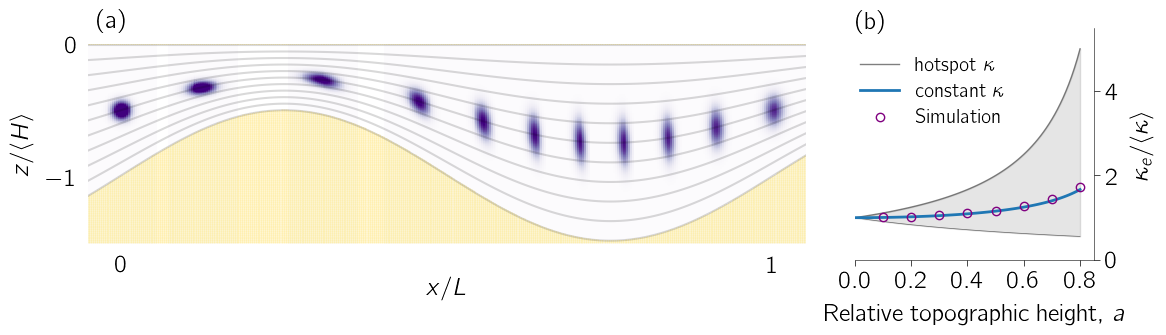

i: 11, step: 16630, ξ/L: 1.00, iξ: 428; fractional tracer center: 0.84


In [111]:
# Make plot
fs = 18
legfs = 14
margin = 0.05
cmin = 0.0
cmax = 10.0
idpx = ceil(Int, nx/30)
mask = sinusoidalbathymetrymask(delta, H, L, X, Y)

plt[:rc]("font", size=fs) 
fig, axs = subplots(ncols=2, figsize=(12, 4), gridspec_kw=Dict("width_ratios"=>[3, 1]))

# Timelapse
sca(axs[1])
removespines()

jldopen(filepath, "r") do file
    steps = parse.(Int, keys(file["timeseries/c"]))
    println(steps)
    nsteps = length(steps)
    for (i, step) in enumerate(steps)
        c = file["timeseries/c/$step"]
        ξ = ∬(X.*c)
        ζ = ∬(Y.*c)
        
        iξ = searchsortedfirst(x, ξ)
        @printf("i: %2d, step: %d, ξ/L: %.2f, iξ: %d; fractional tracer center: %.2f\n", i, step, ξ/L, iξ, iξ/nx)
        ii = (iξ-idpx):(iξ+idpx)
        
        pcolormesh(X[ii, :]/L, Y[ii, :]/H, c[ii, :], cmap="Purples", vmin=cmin, vmax=cmax)
    end
end

# Draw bottom topography
bottom = fill(1.0, size(X))                                                                                      
bottom[.!mask] .= NaN                                                                                                 
pcolormesh(X/L, Y/H, bottom, vmin=0.6, vmax=4, cmap="YlOrRd", alpha=0.2)                                                            

# Draw streamlines                                                                                                    
k₁ = 2π/L                                                                                                             
hh = @. H*(1 - delta*sin(k₁*X))                                                                                       
ψ = Y*U./hh                                                                                                           
dψ = 0.1                                                                                                              
contour(X/L, Y/H, ψ, levels=-1:dψ:0, linewidths=1.5, colors="k", alpha=0.15, linestyles="solid")                

# Formatting                                                                                                            
xlabel(L"x/L", labelpad=0.0, fontsize=fs)
ylabel(L"z/\langle H \rangle", labelpad=8.0, fontsize=fs)
xlim(-margin, 1+margin)
ylim(-(1+delta*1.05), 0.01)
aspectratio(4H/L)
xticks([0, 1])
yticks([-1, 0])
axs[1][:tick_params](left=false, bottom=false, labelsize=fs)


# Diffusion enhancement demonstration
sca(axs[2])


plot(theorydeltas, hotspotenhancements, "-"; color="k", linewidth=1, alpha=0.5,
     label="hotspot \$ \\kappa \$")
plot(theorydeltas, coldspotenhancements, "-"; color="k", linewidth=0.5, alpha=0.5)
     #label="Eq 5, \$ \\kappa \\propto \\delta(x+L/4) \$")
fill_between(hotspotdeltas, hotspotenhancements, coldspotenhancements, color="k", alpha=0.1) 

plot(theorydeltas, theoryenhancements, "-"; color="C0", linewidth=2, 
     label="constant \$ \\kappa \$")  

plot(numericaldeltas, numericalenhancements, "o"; color="Purple", markerfacecolor="none", linewidth=4, 
     label="Simulation")                                                                                              
              
xlabel("Relative topographic height, \$ a \$", labelpad=8.0, fontsize=fs)
ylabel("\$ \\kappa_e/\\langle\\kappa\\rangle \$", labelpad=10.0, fontsize=fs)
cornerspines(side="right")
axisright()
legend(loc="upper left", markerscale=1, fontsize=legfs, bbox_to_anchor=(-0.05, 0.95))
xlim(0, 0.85)
ylim(0, 5.5)
aspectratio(0.15)
xticks([0, 0.2, 0.4, 0.6, 0.8])
axs[2][:tick_params](labelsize=fs)


text(0.01, 1.05, "(a)", transform=axs[1][:transAxes], ha="left", va="bottom", fontsize=fs)
text(0, 0.97, "(b)", transform=axs[2][:transAxes], ha="left", va="bottom", fontsize=fs)

tight_layout(w_pad=0.0)

plotname = "example.png"
savefig(plotname, dpi=960)